# 4. In-silico mutagenesis

We will show here how to mutate all positions in-silico to look how variants can affect gene expression. You can either train the models yourself (see previous tutorials) or download the trained models from Zenodo. 

In [1]:
import os
import copy as cp
import h5py

import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import seaborn as sns

from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from tqdm.notebook import tqdm

### Choose your gene of interest 

Here, we will reproduce the results from the paper and look at CACNA1I.

In [2]:
gene = 'CACNA1I'

Look which index in the h5 file corresponds to this gene and load that sequence.

In [3]:
fn_seq = '../../Zenodo/human/human_seq_hl.h5'
hf = h5py.File(fn_seq, 'r', libver='latest', swmr=True)
gn = np.asarray(hf['geneName']).astype('U30')
hf.close()

In [4]:
idx = np.where(gn == gene)[0]
print(idx)

[2211]


In [5]:
TSS = 70000
upstream = 7000
downstream = 3500

hf = h5py.File(fn_seq, 'r', libver='latest', swmr=True)
sequences = np.asarray(hf['promoter'])[idx,(TSS-upstream):(TSS+downstream),:]
hl = np.array(hf['data'])[idx]
hf.close()

### Initialize the model

In [6]:
os.chdir('../code')

from scEP_cp import CNN1D, evaluate_mut, load_checkpoint

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("[*] Selected device: ", device)

net = CNN1D(num_ct=20).to(device)
print(net)

[*] Selected device:  cuda
CNN1D(
  (conv): Sequential(
    (0): Conv1d(4, 128, kernel_size=(6,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=30, stride=30, padding=1, dilation=1, ceil_mode=False)
    (3): Conv1d(128, 32, kernel_size=(9,), stride=(1,), padding=(4,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=10, stride=10, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fc): Sequential(
    (0): Linear(in_features=1125, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.00099, inplace=False)
    (3): Linear(in_features=64, out_features=20, bias=True)
  )
)


In [8]:
os.chdir('../tutorials/')

### Load true expression values

We need this to undo the z-scoring after we made the predictions.

In [9]:
y_true = pd.read_csv('../../Zenodo/human/M1/subclass/subclass.csv', index_col=0)
y_true.iloc[:5]

,Astro,Endo,L2/3 IT,L5 ET,L5 IT,L5/6 NP,L6 CT,L6 IT,L6 IT Car3,L6b,Lamp5,Micro-PVM,OPC,Oligo,Pvalb,Sncg,Sst,Sst Chodl,VLMC,Vip
WASH7P,-1.305739,-4.0,-0.915789,-0.804866,-0.886611,-0.890142,-0.931289,-0.899425,-0.812872,-0.812913,-1.041932,-4.000000,-1.140033,-1.483413,-0.938450,-1.046027,-1.220408,-0.766559,-4.0,-1.156658
LOC105379213,-4.000000,-4.0,-1.719671,-1.709472,-1.746770,-1.818924,-1.743273,-1.814571,-1.766845,-1.823213,-1.990441,-4.000000,-4.000000,-2.708975,-1.860694,-2.192155,-2.322475,-4.000000,-4.0,-2.150215
LOC729737,-4.000000,-4.0,-0.804495,-0.592176,-0.589227,-0.887951,-0.675321,-1.076636,-0.921747,-1.009648,-1.608346,-0.841344,-4.000000,-4.000000,-1.409335,-1.598436,-1.341327,-0.601251,-4.0,-1.739975
LOC100996442,-4.000000,-4.0,-1.960665,-1.708663,-1.642896,-2.124793,-1.780221,-2.514511,-1.766845,-2.298319,-2.291173,-4.000000,-4.000000,-4.000000,-1.963272,-4.000000,-1.881051,-4.000000,-4.0,-2.450456
LOC102725121,-4.000000,-4.0,-2.678668,-4.000000,-2.791185,-4.000000,-2.824471,-4.000000,-4.000000,-4.000000,-2.893829,-4.000000,-4.000000,-2.629401,-3.143388,-4.000000,-4.000000,-4.000000,-4.0,-4.000000


In [10]:
ct_mapping = y_true.columns

### In-silico mutagenesis

We will use the trained models where our gene of intereset was in the test set, so we first have to find this fold and then we can start mutating the sequence.

In [11]:
# Keep the random_state to 1 otherwise you get a different 
# split than during training!
numgenes = len(gn)
idx_all = np.arange(0, numgenes)
kf = KFold(n_splits=20, shuffle=True, random_state=1)
fold = 0
fold_needed = -1

# Find in which test fold this gene is
for train_val_idx, idx_test in kf.split(idx_all):
    print(fold)
    if np.isin(gene, gn[idx_test]):
        print('We need fold: ' + str(fold))
        fold_needed = fold

        np.random.seed(fold)
        idx_rest = np.random.permutation(numgenes-len(idx_test))
        idx_val = train_val_idx[idx_rest[:1000]]
        idx_train = train_val_idx[idx_rest[1000:]]

        scaler = StandardScaler()
        scaler.fit(y_true.loc[gn[idx_train]])
        break
    fold += 1


0
We need fold: 0


In [12]:
os.chdir('../../Zenodo/human/M1/subclass/')

alphabet = 'ACTG'
ohdict = dict((i, c) for i, c in enumerate(alphabet))

# Predicted effect: Models x positions x cell types x mutations
diff_all = np.zeros((5, 10500, 20, 4))

# Iterate over the 5 models
for m in range(5):

    os.chdir('logmean_multitask_' + str(fold_needed) + '/ckpt_dir' + str(m))
    
    load_checkpoint(net, filename='model_best.pth.tar')
    
    # Original prediction (without mutation)
    y_pred = evaluate_mut(device, net, 
                          np.reshape(np.transpose(sequences), (1,4,10500)),
                          hl)
    y_pred_inv = scaler.inverse_transform(y_pred)

    seq = np.reshape(cp.deepcopy(sequences), (1,10500,4))
    
    # Iterate over all positions
    for i in tqdm(range(10500)):

        diff_posi = np.zeros((20,4))
        
        # Iterate over the three possible mutations
        for j in range(3):
            
            # Induce mutation
            idx_original = np.argmax(seq[:,i])
            idx_tochange = (idx_original+j+1) % 4
            seq_ = cp.deepcopy(seq)
            seq_[0,i,idx_original] = 0
            seq_[0,i,idx_tochange] = 1
            
            # Evaluate mutated sequence
            pred_ = evaluate_mut(device, net, 
                                 np.reshape(np.transpose(seq_), (1,4,10500)),
                                 hl)
            pred_inv = scaler.inverse_transform(pred_)

            # Calculate difference
            diff_all[m,i,:,idx_tochange] = pred_inv - y_pred_inv

    os.chdir('../../')


[*] Loaded checkpoint at epoch 16


  0%|          | 0/10500 [00:00<?, ?it/s]


[*] Loaded checkpoint at epoch 20


  0%|          | 0/10500 [00:00<?, ?it/s]


[*] Loaded checkpoint at epoch 26


  0%|          | 0/10500 [00:00<?, ?it/s]


[*] Loaded checkpoint at epoch 18


  0%|          | 0/10500 [00:00<?, ?it/s]


[*] Loaded checkpoint at epoch 20


  0%|          | 0/10500 [00:00<?, ?it/s]

In [13]:
diff_mean = np.mean(diff_all, axis=0)

### Look at the results

E.g. you can plot the mutation profile

In [14]:
ct = 'Sst Chodl'
idx_ct = np.where(ct_mapping == ct)[0]

ct_effect = np.squeeze(diff_mean[:,idx_ct])
ct_max = np.max(ct_effect, axis=1)
ct_min = np.min(ct_effect, axis=1)

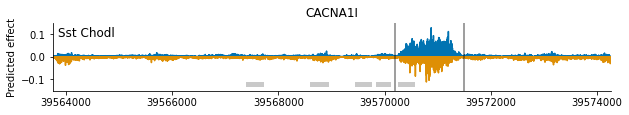

In [15]:
offset = 39563753 #Position on the chromosome of first input base

fig = plt.figure(figsize=(10, 1.25))  
ax = plt.subplot()

# Plot minimum and maximum effect
plt.plot(np.linspace(0, 10499, num=10500)+offset, ct_max, rasterized=True, color=sns.color_palette('colorblind')[0])
plt.plot(np.linspace(0, 10499, num=10500)+offset, ct_min, rasterized=True, color=sns.color_palette('colorblind')[1])

# Add the candidate cis-regulatory elements (downloaded from SCREEN v3)
facecolor=sns.color_palette('colorblind')[7]
edgecolor='none'
alpha=0.5

#EH38E3482229
#EH38E3482230
#EH38E3482231
#EH38E3482232
#EH38E2164864
elements = [[39567387, 39567737],
            [39568602, 39568948],
            [39569441, 39569761],
            [39569835, 39570117],
            [39570245, 39570564]]

rec = [Rectangle((x1, -0.135), x2-x1, 0.025) for x1, x2 in elements]

pc = PatchCollection(rec, facecolor=facecolor, alpha=alpha,
                         edgecolor=edgecolor)
ax.add_collection(pc)

plt.ticklabel_format(useOffset=False, style='plain')
plt.title(gene)
plt.ylabel('Predicted effect')

# Location we're going to zoom in on
plt.axvline(39570200, color='k', alpha=0.5)
plt.axvline(39571500, color='k', alpha=0.5)

plt.text(0.01, 0.95, ct,
         verticalalignment='top', horizontalalignment='left',
         transform=ax.transAxes, fontsize=12)

sns.despine()

plt.xlim([39563753, 39574253])
plt.ylim([-0.15, 0.15])
plt.xticks([39564000, 39566000, 39568000, 39570000, 39572000, 39574000], 
           [39564000, 39566000, 39568000, 39570000, 39572000, 39574000])

plt.show()